![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)

# Prompt Tuning for Multi-class Classification with watsonx

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.

# Overview

## Audience

This notebook is part of a series of notebooks, designed to guide you on how to utilize watsonx.ai Large Language Models (LLMs) for text classification.

The scenario presented in this notebook assumes you have a few hunderds or thousands of *labeled text elements* in a *multi-class* setup, that is, each text element is labeled to exactly one class from a given taxonomy.

Some familiarity with Python is helpful. This notebook runs with python 3.10.

## Prompt Tuning

Full fine-tuning of LLMs requires significant resources. To this end, watsonx provides Prompt Tuning (PT), a parameter-efficient tuning method where the pre-trained model parameters are frozen and a soft prompt is trained on the labeled data provided. Compared to prompt-engineering, PT allows the LLMs to learn from much more examples, avoiding the prompt length limitation, and aiming at deeper adaptation to the given data. For more details, please refer to <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-tuning-methods.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">our documentation.</a>

## Learning goal

- The goal of this notebook is to provide an end-to-end step-by-step walkthrough of using Prompt Tuning in watsonx for multi-class classification, assuming labeled data exists, and demonstrating how to:
    - Upload a data asset
    - Setup and run prompt tuning
    - Deploy tuned model
    - Infer tuned model on test data
    - Evaluate model performance
- We provide advanced steps for making the best of your tuning in various scenarios. For example -
    - What to do if you have too many categories and they don't fit in the verbalizer?
    - How to initialize the soft prompt for classification?
- The notebook is backed by empirical evidence over 9 benchmark datasets showing an average improvement of ~16 points in macro-f1 compared to zero-shot classification with the same model, and ~13 points compared to zero-shot classification with a larger model (see details in the [Benchmark Results](#benchmark) section).

## Contents

This notebook contains the following parts:

- [Setup](#setup)
- [Load data](#load_data)
- [Initialize experiment](#experiment)
- [Run Prompt Tuning](#run_tuning)
- [Deploy](#deploy)
- [Run Foundation Models Inference on `watsonx.ai`](#inference)
- [Evaluate tuned model](#evaluation)
- [Benchmark Results](#benchmark)
- [Summary](#summary)

<a id="setup"></a>
# Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a Watson Machine Learning (WML) Service instance. Information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/admin/create-services.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>. A paid instance is required to use Tuning Studio.

## Install dependencies

In [1]:
!pip install ibm-watsonx-ai -U -q 
!pip install scikit-learn -q 
!pip install matplotlib -q 
!pip install wget -q
!pip install graphviz -q
!pip install tqdm -q

## Import utility packages

In [2]:
import os
import getpass

### Watsonx API connection
This cell defines the credentials required to work with watsonx API for Foundation
Model inferencing.

**Action:** Provide the IBM Cloud user API url and API key. For details, see <a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank" rel="noopener no referrer">documentation</a>.

In [3]:
try:
    api_url = os.environ["API_URL"]
except KeyError:
    api_url = getpass.getpass("Please enter your watsonx.ai URL domain (hit enter): ")

Please enter your watsonx.ai URL domain (hit enter): ········


In [4]:
try:
    api_key = os.environ["API_KEY"]
except KeyError:
    api_key = getpass.getpass("Please enter your watsonx.ai API key (hit enter): ")

Please enter your watsonx.ai API key (hit enter): ········


## Define the project id

The Foundation Model requires a project id that provides the context for the call. We will try to obtain the id from the project in which this notebook runs. Otherwise, please provide the project id. To find your project id, select the project from the [project list](https://dataplatform.cloud.ibm.com/projects/?context=wx), and then take the project id from `Manage`->`General`->`Details`.

In [5]:
try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = getpass.getpass("Please enter your watsonx.ai Project ID (hit enter): ")

Create an instance of APIClient with authentication details, and set the project id.

In [6]:
credentials={
    "url": api_url,
    "apikey": api_key
}

In [7]:
from ibm_watsonx_ai import APIClient

In [8]:
client = APIClient(credentials)

In [9]:
client.set.default_project(project_id)

'SUCCESS'

<a id="load_data"></a>
# Load data

The recommended data size is between a few hundred and a few thousand examples. In case your data is much larger (e.g., 100k examples), you should probably randomly sample from it, to reduce runtime.

For more details read about <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-tuning-data.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">data formats</a> in our documentation.

Recommendations:
- Make sure class names are not too similar. E.g, `bank account` and `my bank account`. Class names which are too similar might confuse the model.
- Make sure each class is represented well enough. Models may have a hard time to predict classes that have a small number of examples in the train data.

## Use CFPB data

To illustrate the use of PT on multi-class data, we will use a subset of the CFPB (Consumer Financial Protection Bureau) dataset (for more details about the dataset [click here](https://www.consumerfinance.gov/data-research/consumer-complaints/)). This dataset contains millions of real complaints, originally associated with 9 different products (topics). The samples we will use for training and testing in this notebook are downloaded from our git repository and cover a slightly different list of 5 products. We will use separate samples of 1k examples for training and testing.

## Use your own data

Alternatively, you can run this notebook with your own data. For this purpose, set the variable `use_your_own_data` to `True`. In the subsequent cell, set the path to your data in csv format, the text and label column names, the train asset filename and the path to the test file in csv format (if exists).

In [10]:
use_your_own_data = False

In [11]:
import wget

In [12]:
# Define download data function
def download_cfpb(filepath):
    url = f"https://raw.github.com/IBM/watson-machine-learning-samples/master/cloud/data/cfpb_complaints/{filepath}"
    wget.download(url)

In [13]:
if not use_your_own_data:
    print("downloading cfpb data")
    filepath = "cfpb_compliants.csv"
    download_cfpb(filepath)
    text_column = "narrative"
    label_column = "product"
    asset_train_filename = "CFPB_train.json"
    
else:
    print("defining custom data parameters")
    filepath = "" # the path to your data
    text_column = "" # the column name for the input texts
    label_column = "" # the column name for gold labels
    asset_train_filename = "my_train.json" # the name of the file that is created for the train data asset (in json format)
    test_filepath = None # optionally, set a path to your test data for evaluation

downloading cfpb data


We preprocess the data. For CFPB, originally the labels contain underscores that we convert to spaces (e.g., `credit_reporting`->`credit reporting`). If you use your own data, you can update this function with additional preprocessing steps for your dataset.

In [14]:
import pandas as pd

In [15]:
# preprocessing cfpb data - update this function with relevant preprocessing of your data
def preprocess(df, text_column, label_column):
    print("preprocessing data")
    df = df.rename(columns={text_column: "input", label_column: "output"})
    df = df[['input', 'output']]
    df.loc[:, "output"] = df["output"].apply(lambda l: l.replace("_", " "))
    return df

In [16]:
df = pd.read_csv(filepath)
df = preprocess(df, text_column, label_column)

preprocessing data


We create a data asset for training.

In [17]:
import json

In [18]:
assets = client.data_assets.get_details()['resources']
assets = [a for a in assets if a['metadata']['name'] == asset_train_filename]

In [19]:
def get_demo_train_data(df):
    return df.loc[:999, :]

In [20]:
if len(assets) == 0:
    print("\ntrain asset does not exist")
    if not use_your_own_data:
        train_df = get_demo_train_data(df)
    else:
        train_df = df
    data = train_df.to_dict("records")
    with open(asset_train_filename, "w") as f:
        json.dump(data, f)
    train_asset = client.data_assets.create(name=asset_train_filename, file_path=asset_train_filename)
else:
    print(f"\ntrain asset {asset_train_filename} exists")
    train_asset = assets[0]
    asset_uid = client.data_assets.get_uid(train_asset)
    content = client.data_assets.get_content(asset_uid).decode("utf-8")
    train_df = pd.read_json(content, orient="records")


train asset does not exist
Creating data asset...
SUCCESS


We sort the class names lexicographically (to maintain a consistent order), and check that there are enough examples for each class.

In [21]:
from collections import Counter

In [22]:
class_names = sorted(set(train_df["output"]))
sorted_classes_by_freq = Counter(train_df["output"]).most_common()
print(f"Frequency of classes in the train set: {sorted_classes_by_freq}")
classes_with_less_than_twenty_examples = [c for c in sorted_classes_by_freq if c[1] < 20]
if len(classes_with_less_than_twenty_examples) > 0:
    print("Note, the following classes have less than 20 examples in the train set. This may harm their performance:")
    print(classes_with_less_than_twenty_examples)

Frequency of classes in the train set: [('debt collection', 236), ('credit reporting', 233), ('mortgages and loans', 213), ('credit card', 190), ('retail banking', 128)]


We define a `DataConnection` instance for the training data. This instance will be used as reference when running PT later.

In [23]:
train_asset_id = client.data_assets.get_id(train_asset)

In [24]:
from ibm_watsonx_ai.helpers import DataConnection

In [25]:
data_conn = DataConnection(data_asset_id=train_asset_id)

<a id="experiment"></a>
# Initialize experiment

We initialize an instance of `TuneExperiment` using the `project_id`.

In [26]:
from ibm_watsonx_ai.experiment import TuneExperiment

In [27]:
experiment = TuneExperiment(credentials, project_id=project_id)

## Initialize a verbalizer

We initialize the verbalizer used in training. We set two verbalizers:

- An instruction for classification that includes a list of candidate class names.
- An alternative instruction which does not contain the class names, thus requiring less tokens.

As a subsequent step we will determine which verbalizer to use on this data.

Note: Based on our experiments, the importance of the actual phrasing of the verbalizer decreases when you have a reasonable amount of labeled data (at least 10-20 instances for each class or 300-400 overall). If the size of your data is smaller than that, you may want to consider testing other verbalizers that reflect your domain or type of text. E.g., if your use-case involves classification of legal clauses, the instruction could be `classify the legal clause into one the following categories { "class_1", "class_2", ...}`, the input prefix could be `legal clause:`, and the output prefix could be `category:`. 

In [28]:
input_prefix_val = "Input:"
output_prefix_val = "Output:"
instruction_with_class_names_val = 'classify { '+ ", ".join(['"' + c + '"' for c in class_names]) + ' }'
instruction_without_class_names_val = 'classify the following text:'

In [29]:
def get_class_names_verbalizer(class_names):
    instruction = instruction_with_class_names_val
    input_prefix = input_prefix_val
    output_prefix = output_prefix_val
    verbalizer = instruction + ' ' + input_prefix + ' {{input}} ' + output_prefix
    return verbalizer

In [30]:
class_names_verbalizer = get_class_names_verbalizer(class_names)
print(f"With class names\n{class_names_verbalizer}")

With class names
classify { "credit card", "credit reporting", "debt collection", "mortgages and loans", "retail banking" } Input: {{input}} Output:


In [31]:
def get_no_class_names_verbalizer():
    instruction = instruction_without_class_names_val
    input_prefix = input_prefix_val
    output_prefix = output_prefix_val
    verbalizer = instruction + ' ' + input_prefix + ' {{input}} ' + output_prefix
    return verbalizer

In [32]:
no_class_names_verbalizer = get_no_class_names_verbalizer()
print(f"Without class names\n{no_class_names_verbalizer}")

Without class names
classify the following text: Input: {{input}} Output:


## Determine which verbalizer to use

The default token limit for inputs (verbalizer + text) for tuning is 256 tokens. Thus, the actual input might not fit entirely per this limit if we have many classes in the dataset, and/or the input texts are relatively long.

The following cell estimates the length of the verbalizer in tokens.

If the verbalizer with all class names takes up more than 256 tokens, it means they won't fit in the input and the tuning may produce poor performance. In this case, we fallback to the verbalizer without the class names.



### Count the number of tokens in the verbalizer

In [33]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

In [34]:
generate_params_for_verbalizer = {
    GenParams.MAX_NEW_TOKENS: 1,
    GenParams.DECODING_METHOD: 'greedy',
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TRUNCATE_INPUT_TOKENS: 4096,
    GenParams.RETURN_OPTIONS: {'input_text': False, 'generated_tokens': False, 'input_tokens': True, 'token_logprobs': False, 'token_ranks': False, 'top_n_tokens': 0}
}

In [35]:
from ibm_watsonx_ai.foundation_models import ModelInference
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes

In [36]:
base_model_for_verbalizer = ModelInference(
    model_id=ModelTypes.FLAN_T5_XL,
    params=generate_params_for_verbalizer,
    api_client=client
)

In [37]:
def get_verbalizer_num_tokens(verbalizer):
    batch = [verbalizer.replace("{{input}}", "")]
    predictions = base_model_for_verbalizer.generate_text(prompt=batch, raw_response=True)
    verbalizer_num_tokens = predictions[0]['results'][0]['input_token_count']
    return verbalizer_num_tokens

### Create the actual verbalizer

In [38]:
token_limit = 256
    
verbalizer_token_count = get_verbalizer_num_tokens(class_names_verbalizer)
print(f"Estimated verbalizer length: {verbalizer_token_count}")
if verbalizer_token_count >= token_limit:
    verbalizer_token_count = get_verbalizer_num_tokens(no_class_names_verbalizer)
    verbalizer = no_class_names_verbalizer
    print("The verbalizer itself might be longer than the permitted token limit. We fallback to the generic verbalizer.")
    class_names_in_train_verbalizer = False
else:
    verbalizer = class_names_verbalizer
    print("Using verbalizer with class names")
    class_names_in_train_verbalizer = True

Estimated verbalizer length: 40
Using verbalizer with class names


We then estimate the average length of texts to assess the difference between their length and the space they have in the prompt. If this difference is large - that is, the texts will be heavily trimmed - you may want to consider using the verbalizer without the class names to allow more space for the texts.

Note: texts which will not fit the token limit are trimmed automatically, keeping the prefix. You may want to consider trimming the texts in advance to keep the most important parts of your data, e.g., if in your data the end of the text is more important than the opening.

In [39]:
# estimating text token length

texts = train_df["input"].tolist()
text_token_count = [len(t.split()) * 1.5 for t in texts]
avg_text_length = sum(text_token_count)/len(text_token_count)
print(f"Estimated number tokens in verbalizer remaining for texts: {token_limit-verbalizer_token_count}")
print(f"Estimated average length of texts in the train set: {'{:.2f}'.format(avg_text_length)}")
if token_limit - verbalizer_token_count < avg_text_length:
    print(f"If the number of tokens remaining for texts is much smaller than their actual length, this might harm performance.")

Estimated number tokens in verbalizer remaining for texts: 216
Estimated average length of texts in the train set: 151.98


## Set the soft prompt initialization text

The process of PT trains a `soft prompt` - a list of 100 token embeddings - instead of the entire model. To achieve satisfactory results with the model tuned in this notebook (`google/flan-t5-xl`), it is recommended to initialize the soft prompt tokens with the following:
* An instruction that is relevant for the task. 
* The candidate classes sorted by their frequency in the train set.
* In certain cases (and only if the instruction and the candidate classes are together substansially shorter than 100 tokens), it could be helpful to provide a longer instruction, to fill out the 100 tokens of the soft prompt.

This initialization presumably allows a more semantically meaningful starting point for the soft prompt embeddings. We set the inialization text in the `soft_prompt_initialization_text` parameter.

In [40]:
class_names_order_by_prior = [c[0] for c in sorted_classes_by_freq]
soft_prompt_initialization_text = "Classify the text into one of the following categories: " + ", ".join(class_names_order_by_prior)
print(f"The soft prompt initialization text: \n{soft_prompt_initialization_text}\n")

The soft prompt initialization text: 
Classify the text into one of the following categories: debt collection, credit reporting, mortgages and loans, credit card, retail banking



## Define prompt tuner

We define the `prompt_tuner` parameters, including the verbalizer and the initialization text. Tuning is currently available for `google/flan-t5-xl`.

Note: We set the number of epochs to 50 (`num_epochs` parameter), as this usually provided the best results in our experiments. You may want to consider decreasing the number of epochs to save on run-time, especially if your dataset contains more than 1k elements, with potential decrease in performance.

In [41]:
from ibm_watsonx_ai.foundation_models.utils.enums import PromptTuningInitMethods

In [42]:
prompt_tuner = experiment.prompt_tuner(name="sample SDK run auto_update True on CFPB",
                                       task_id=experiment.Tasks.CLASSIFICATION,
                                       base_model=ModelTypes.FLAN_T5_XL,
                                       accumulate_steps=16,
                                       batch_size=16,
                                       learning_rate=0.3,
                                       max_input_tokens=token_limit,
                                       max_output_tokens=20,
                                       num_epochs=50,
                                       tuning_type=experiment.PromptTuningTypes.PT,
                                       verbalizer=verbalizer,
                                       auto_update_model=True,
                                       init_method=PromptTuningInitMethods.TEXT,
                                       init_text=soft_prompt_initialization_text
                                       )

In [43]:
prompt_tuner.get_params()

{'base_model': {'model_id': 'google/flan-t5-xl'},
 'accumulate_steps': 16,
 'batch_size': 16,
 'init_method': 'text',
 'init_text': 'Classify the text into one of the following categories: debt collection, credit reporting, mortgages and loans, credit card, retail banking',
 'learning_rate': 0.3,
 'max_input_tokens': 256,
 'max_output_tokens': 20,
 'num_epochs': 50,
 'task_id': 'classification',
 'tuning_type': 'prompt_tuning',
 'verbalizer': 'classify { "credit card", "credit reporting", "debt collection", "mortgages and loans", "retail banking" } Input: {{input}} Output:',
 'name': 'sample SDK run auto_update True on CFPB',
 'description': 'Prompt tuning with SDK',
 'auto_update_model': True,
 'group_by_name': False}

<a id="run_tuning"></a>
# Run Prompt Tuning

We run a prompt tuning process of foundation models on top of the training data referenced by DataConnection (tuning may take some time).

By setting the `background_mode` parameter to `True`, the prompt tuning process will run in the background.

In [44]:
tuning_details = prompt_tuner.run(training_data_references=[data_conn], background_mode=True)

PT over 1k examples of the CFPB data takes about 50 minutes. If `background_mode` is set to `True`, we use the following utility function to probe the status of training. Run this cell, and it will finish when training is completed.

In [45]:
print(tuning_details)

{'metadata': {'created_at': '2024-01-30T17:16:18.891Z', 'description': 'Prompt tuning with SDK', 'id': 'c9eccc2d-b354-463b-a607-258a9b7eff3c', 'modified_at': '2024-01-30T17:16:18.891Z', 'name': 'sample SDK run auto_update True on CFPB', 'project_id': '7d0667b5-00b6-4f34-b002-13a1f5db1676', 'tags': ['prompt_tuning', 'wx_prompt_tune.07b351a6-7899-4aae-8ad6-65fd68706591']}, 'entity': {'auto_update_model': True, 'description': 'Prompt tuning with SDK', 'name': 'sample SDK run auto_update True on CFPB', 'project_id': '7d0667b5-00b6-4f34-b002-13a1f5db1676', 'prompt_tuning': {'accumulate_steps': 16, 'base_model': {'model_id': 'google/flan-t5-xl'}, 'batch_size': 16, 'init_method': 'text', 'init_text': 'Classify the text into one of the following categories: debt collection, credit reporting, mortgages and loans, credit card, retail banking', 'learning_rate': 0.3, 'max_input_tokens': 256, 'max_output_tokens': 20, 'num_epochs': 50, 'num_virtual_tokens': 100, 'task_id': 'classification', 'tuning_

In [46]:
import time

In [47]:
model_id = tuning_details['metadata']['id']

In [48]:
def wait_till_model_is_ready(tuning_details):
    while True:
        status = prompt_tuner.get_run_status()
        print(f'Model {model_id} is {status}')
        if status == 'completed':
            break
        elif status not in ['initializing', 'pending', 'running']:
            raise ValueError(f'Unexpected tune status: {status}')
        time.sleep(60)

In [49]:
wait_till_model_is_ready(tuning_details)

Model c9eccc2d-b354-463b-a607-258a9b7eff3c is pending
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is pending
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is pending
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a607-258a9b7eff3c is running
Model c9eccc2d-b354-463b-a60

<a id="run_details"></a>
## Prompt Tuning details

Get a summary of the tuning process.

In [50]:
prompt_tuner.summary()

,Enhancements,Base model,Auto store,Epochs,loss
Model Name,,,,,
model_c9eccc2d-b354-463b-a607-258a9b7eff3c,[prompt_tuning],google/flan-t5-xl,True,50,0.15961


Plot the learning curves. The left most curve shows the loss over the epochs. A good tuning process is one where the loss gradually decreases as training progresses.

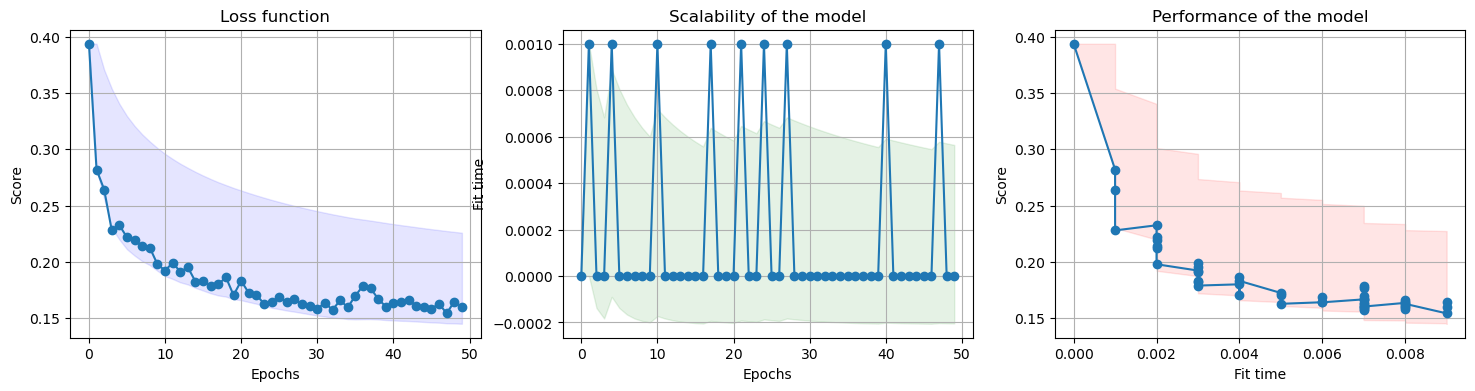

In [51]:
prompt_tuner.plot_learning_curve()

<a id="deploy"></a>
# Deploy

We deploy the model using the `model_id` variable.

In [52]:
model_id = prompt_tuner.get_run_details()['entity']['model_id']
print(model_id)

5b538d7e-9a80-46ab-83ba-2215401f8b2c


In [53]:
from datetime import datetime

In [54]:
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "PT DEPLOYMENT SDK - project",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.SERVING_NAME : f"pt_sdk_deployment_{datetime.utcnow().strftime('%Y_%m_%d_%H%M%S')}"
}
deployment_details = client.deployments.create(model_id, meta_props)



#######################################################################################

Synchronous deployment creation for uid: '5b538d7e-9a80-46ab-83ba-2215401f8b2c' started

#######################################################################################


initializing.
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='fd95312f-38db-47e0-8dea-84404dc55895'
------------------------------------------------------------------------------------------------




We store the deployment id which will be used for inference.

In [ ]:
deployment_details

In [56]:
deployment_id = client.deployments.get_id(deployment_details)
print(deployment_id)

fd95312f-38db-47e0-8dea-84404dc55895


<a id="inference"></a>
# Run Foundation Models Inference on watsonx.ai



We define the generation parameters. 

- We use `greedy` decoding method because we want the model to return the most probable class name for the given text.
- The overall token limit for inference of the tuned model is 4096 (inputs and outputs combined). 100 of them are saved for the tuned soft prompt, and 20 for the output, so 3976 tokens remain for the input. We set `TRUNCATE_INPUT_TOKENS` to 3975 to trim inputs which are longer than that.

In [57]:
generate_params = {
    GenParams.MAX_NEW_TOKENS: 20,
    GenParams.DECODING_METHOD: 'greedy',
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TRUNCATE_INPUT_TOKENS: 3975
}

We define an instance of `ModelInference` using the `deployment_id` and the generation parameters.

In [58]:
tuned_model = ModelInference(
    deployment_id=deployment_id,
    params=generate_params,
    api_client=client
)

## Run inference

If you chose to run with the demo data, we take the test data from the original CFPB dataframe. Otherwise, the test data is taken from the path specified in the variable `test_filepath` in the cell `Use your own data`.

Note: We perform the same preprocessing for the test set as done for the train set. It is assumed they share identical column names.

In [59]:
def get_demo_test_data(df):
    return df.loc[1000:1999, :]

In [60]:
def get_test_data(filepath):
    return pd.read_csv(filepath)

In [61]:
if not use_your_own_data:
    test_df = get_demo_test_data(df)
else:
    if test_filepath is None:
        raise Exception("you need set a path to a test file to continue (in cell \"Use your own data\")")
    test_df = get_test_data(test_filepath)
    test_df = preprocess(test_df, text_column, label_column)

We check there are enough examples for each class in the test set.

In [62]:
eval_classes = Counter(test_df["output"]).most_common()
classes_with_less_than_ten_examples = [c for c in eval_classes if c[1] < 10]
if len(classes_with_less_than_ten_examples) > 0:
    print("Note, the following classes have less than 10 examples in the test set. It could be hard to deduce how well the model performs on them.")
    print(classes_with_less_than_ten_examples)

In case the verbalizer used in tuning contained the class names, there is no need to add them in inference. On the other hand, if the verbalizer without the class names was selected for tuning, we add them in inference.

In [63]:
if class_names_in_train_verbalizer:
    prompts_batch = test_df["input"].tolist()
else:
    prompts_batch = [class_names_verbalizer.replace("{{input}}", text) for text in test_df["input"]]
labels = test_df["output"].tolist()

We infer the tuned model over the test data.

Occasionally, the output of the model may yield class names which are not part of the original class list. From our experiments, such hallucinations usually occur for ~1% of the examples on average.

For this purpose we use a utility function from the `difflib` package to find the most similar class to the generated text. If none is found, we use the class with the highest prior in the train set.

Note: In case inference fails, try waiting a few seconds and running the cell again. If it fails, you may want to re-run the `Deploy` section and then try inference again.

In [64]:
import time
import difflib

In [66]:
start = time.time()
print(f"Running inference on {len(prompts_batch)} examples")
predictions = tuned_model.generate_text(prompt=prompts_batch)    
predictions = [(difflib.get_close_matches(res, class_names) + [class_names_order_by_prior[0]])[0] for res in predictions]
end = time.time()
print(f"elapsed time: {end - start}")

Running inference on 1000 examples
elapsed time: 59.58870577812195


<a id="evaluation"></a>
# Evaluate tuned model

We evaluate the predictions with respect to the labels. We calculate accuracy, micro-f1, macro-f1 and f1 per class.

In [67]:
from sklearn.metrics import accuracy_score, f1_score

In [68]:
def get_labels_in_binary_form(label, class_names):
    return [1 * (cls == label) for cls in class_names]

In [69]:
def get_metrics(labels, predictions):
    binary_labels = [get_labels_in_binary_form(l, class_names) for l in labels]
    binary_preds = [get_labels_in_binary_form(p, class_names) for p in predictions]
    f1_per_class = f1_score(binary_labels, binary_preds, average=None)
    
    return {
        f'accuracy': f'{accuracy_score(binary_labels, binary_preds)*100:.2f}',
        f'micro_f1': f'{f1_score(binary_labels, binary_preds, average="micro")*100:.2f}',
        f'macro_f1': f'{f1_score(binary_labels, binary_preds, average="macro")*100:.2f}',
        f'f1_per_class': (pd.Series(f1_per_class, index=class_names)*100.).round(2),
    }

In [70]:
performance = get_metrics(labels, predictions)
print(performance)

{'accuracy': '81.40', 'micro_f1': '81.40', 'macro_f1': '81.61', 'f1_per_class': credit card            78.65
credit reporting       79.62
debt collection        74.87
mortgages and loans    88.26
retail banking         86.67
dtype: float64}


## Compare to base model

This cell is optional, and is used to compare the tuned model to the same model in a zero-shot setup. On the dataset we are using in this notebook, the gain with the tuned model is around ~21 macro-f1 points.

We initialize the `ModelInference` class with base model, and infer over the test data.

We need to provide the base model with the zero-shot prompt for the task. We use the prompt that is defined in the `verbalizer`.

In [71]:
generate_params = {
    GenParams.MAX_NEW_TOKENS: 20,
    GenParams.DECODING_METHOD: 'greedy',
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TRUNCATE_INPUT_TOKENS: 4096,
}

In [72]:
base_model = ModelInference(
    model_id=ModelTypes.FLAN_T5_XL,
    params=generate_params,
    api_client=client
)

In [73]:
base_prompts_batch = [class_names_verbalizer.replace("{{input}}", text) for text in test_df["input"]]

In [74]:
base_predictions = base_model.generate_text(prompt=base_prompts_batch)
base_predictions = [(difflib.get_close_matches(res, class_names) + [class_names_order_by_prior[0]])[0] for res in base_predictions]

In [75]:
performance = get_metrics(labels, base_predictions)
print(performance)

{'accuracy': '61.30', 'micro_f1': '61.30', 'macro_f1': '60.98', 'f1_per_class': credit card            72.35
credit reporting       61.64
debt collection        40.63
mortgages and loans    56.00
retail banking         74.29
dtype: float64}


## Compute confusion matrix

It can be helpful to investigate common cases where the model confuses between one class to another. Such pairs of classes could indicate that the difference between them is too subtle for the model to distiguish, or that the labeled data is noisy.

For this purpose, we compute a confusion matrix using model predictions versus the gold labels over the test set.

Note: It is assumed the set of labels in the train and test splits are identical.

In [76]:
from sklearn.metrics import confusion_matrix

In [77]:
evaluation_df = pd.DataFrame({'label': labels, 'prediction': predictions})

In [78]:
def compute_confusition_matrix(evaluation_df):
    labels = evaluation_df.label.tolist()
    labels_sorted = sorted(list(set(labels)))
    print(labels_sorted)
    
    predictions = evaluation_df.prediction.tolist()
    cm = confusion_matrix(y_true=labels, y_pred=predictions, labels=labels_sorted)
    df = pd.DataFrame(cm)
    df.columns = labels_sorted
    df.index = labels_sorted
    print(df)

In [79]:
compute_confusition_matrix(evaluation_df)

['credit card', 'credit reporting', 'debt collection', 'mortgages and loans', 'retail banking']
                     credit card  credit reporting  debt collection  \
credit card                  140                11                3   
credit reporting              10               207               24   
debt collection               13                37              149   
mortgages and loans            4                12                6   
retail banking                 9                 4                0   

                     mortgages and loans  retail banking  
credit card                            6              20  
credit reporting                       6               2  
debt collection                       14               3  
mortgages and loans                  188               2  
retail banking                         0             130  


<a id="benchmark"></a>
# Benchmark Results

We compared the performance achieved by running PT in the setup described in this notebook to zero-shot classification using Flan-t5-xl / xxl on 9 benchmark datasets (including one dataset which appears in two versions). We report `macro-f1` results. As depicted in the table below, PT results provide a significant improvement in almost all datasets.

- Sentiment and Email Classification are IBM internal datasets, while the rest are publicly available.
- The bottom 4 datasets have a large number of classes, which do not fit the PT train input token limit. For running PT over these datasets we use the verbalizer without class names (as described in section `Estimate how well classes and texts fit in the input`). For zero-shot we use the verbalizer with class names throughout.
- The PT training is done on a random sample of 1k examples. Testing of all models is done on a separate random sample of 1k examples.

| Dataset | Number of classes | PT verbalizer | Flan-t5-xl PT (this notebook) | Flan-t5-xl zero-shot | Flan-t5-xxl zero-shot |
| --- | --- | --- | :-: | :-: | :-: |
| Sentiment Classification | 3 | with classes | **82.53** | 74.64 | 75.68 |
| CFPB (notebook version) | 5 | with classes |  **81.61** | 60.97 | 67.26 |
| CFPB | 9 | with classes |  **75.2** | 72.54 | 74.34 |
| Email Classification | 9 | with classes | **59.44** | 9.86 | 19.7 |
| 20 Newsgroup | 20 | with classes |  **80.73** | 62.1 | 59.44 |
| News Classification | 40 | with classes | **39.74** | 27.82 | 31.83 |
| Arg-Topic | 71 | without classes | **97.77** | 95.07 | 96.65 |
| banking77 | 77 | without classes | **63.39** | 51.3 | 55.51 |
| LEDGAR | 98 | without classes | **60.26** | 40.04 | 38.22 |
| clinc150 | 150 | without classes | **74.45** | 61.78 | 70.47 |
| ***Mean*** |  | |  **71.53** | 55.65 | 58.91 |

<a id="summary"></a>
# Summary

Congratulations, you have successfully trained a model using watsonx Prompt Tuning!

Check out our <a href="https://ibm.github.io/watsonx-ai-python-sdk/" target="_blank" rel="noopener no referrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts.

**Author: Shai Gretz**, LM Utilization Team, IBM Research.

Copyright © 2023 IBM. This notebook and its source code are released under the terms of the MIT License.